In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found


In [8]:
# We can use this code to LIST TABLE COLUMNS in SQLite
inspector = inspect(engine)
for table_name in inspector.get_table_names():
    print(table_name)
    print('_________')
    for column in inspector.get_columns(table_name):
        print(column['name'],column['type'])
    print('..................')

measurement
_________
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
..................
station
_________
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
..................


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Get Last data point in DB
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date.date
last_date

'2017-08-23'

In [12]:
year, month, day = last_date.split('-')
f'{year}-{month}-{day}'

'2017-08-23'

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(int(year)-1,int(month),int(day))
year_ago

datetime.date(2016, 8, 23)

In [14]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > year_ago).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(results, columns=['date','precipitation'])
df = df.set_index('date')
df = df.sort_index()
df

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


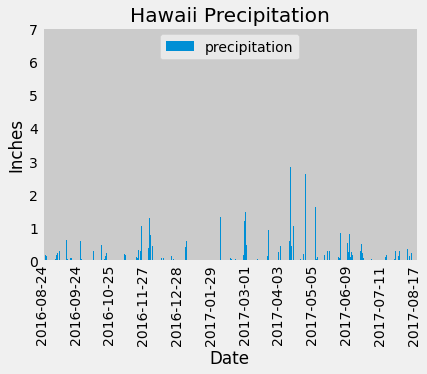

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(kind='bar')
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 200) != 0:
        t.set_visible(False)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Hawaii Precipitation')
plt.savefig('Images/HawaiiPrecipitaion_BAR.png')
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
for value in results:
    print(value)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first().station
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station==active_station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

In [22]:
last_date = session.query(Measurement.date).filter(Measurement.station==active_station).order_by(Measurement.date.desc()).first()
last_date = last_date.date
last_date

'2017-08-18'

In [23]:
year, month, day = last_date.split('-')
f'{year}-{month}-{day}'

'2017-08-18'

In [24]:
year_ago = dt.date(int(year)-1,int(month),int(day))
year_ago

datetime.date(2016, 8, 18)

In [25]:
results = session.query(Measurement.tobs).filter(Measurement.station==active_station).filter(Measurement.date>=year_ago).all()
df = pd.DataFrame(results)

In [26]:
df

,tobs
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0
...,...
352,77.0
353,77.0
354,76.0
355,76.0


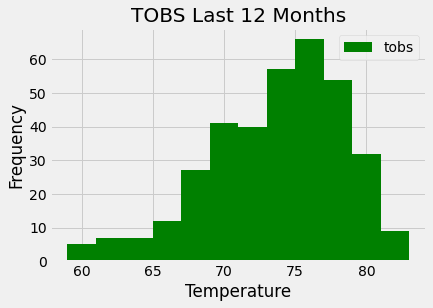

In [36]:
df.plot.hist(bins=12, color='green')
plt.title("TOBS Last 12 Months")
plt.xlabel("Temperature")
plt.savefig('Images/TOBS Last 12 Months_HIST.jpg')
plt.show()

## Bonus Challenge Assignment

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [35]:
# Plot the daily normals as an area plot with `stacked=False`
